# Load dataset from deepchem
### We also provide a downloaded dataset in datasets directory

In [13]:
import deepchem as dc
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from rdkit import Chem
from lime import lime_tabular

bace_dataset = dc.molnet.load_bace_classification(featurizer='ECFP', seed=0, splitter='random')
tasks, dataset, transforms = bace_dataset
train, val, test = dataset

In [14]:
train_x, train_y, train_w, train_ids = train.X, train.y, train.w, train.ids
val_x, val_y, val_w, val_ids = val.X, val.y, val.w, val.ids
test_x, test_y, test_w, test_ids = test.X, test.y, test.w, test.ids
print(f"Shape of train data: {train_x.shape}")
print(f"Shape of train labels: {train_y.shape}")

Shape of train data: (1210, 1024)
Shape of train labels: (1210, 1)


## We can easily find sveral ML models with promising results

In [15]:
rf = RandomForestClassifier(random_state = 42, n_estimators=100)
rf.fit(train_x, train_y)
pred_rf = rf.predict(test_x)
print(f"Accuracy score: {accuracy_score(test_y, pred_rf)}")
print(f"ROC-AUC score: {roc_auc_score(test_y, pred_rf)}")
print(f"MCC score: {precision_score(test_y, pred_rf)}")
print(f"Recall score: {recall_score(test_y, pred_rf)}")

/home/sichao/anaconda3/envs/deepchem-test/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy score: 0.8223684210526315
ROC-AUC score: 0.8220779220779221
MCC score: 0.8125
Recall score: 0.8441558441558441


In [16]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(train_x, train_y)
pred_xgb = xgb_classifier.predict(test_x)
print(f"Accuracy score: {accuracy_score(test_y, pred_xgb)}")
print(f"ROC-AUC score: {roc_auc_score(test_y, pred_xgb)}")
print(f"MCC score: {precision_score(test_y, pred_xgb)}")
print(f"Recall score: {recall_score(test_y, pred_xgb)}")

Accuracy score: 0.7763157894736842
ROC-AUC score: 0.7762770562770563
MCC score: 0.7792207792207793
Recall score: 0.7792207792207793


In [11]:
# Train a SVM on the training set and explain the same instance from the testing set
from sklearn.svm import SVC
svm = SVC(probability=True)
svm.fit(train_x, train_y)
pred_svm = svm.predict(test_x)
print(f"Accuracy score: {accuracy_score(test_y, pred_svm)}")
print(f"ROC-AUC score: {roc_auc_score(test_y, pred_svm)}")
print(f"MCC score: {precision_score(test_y, pred_svm)}")
print(f"Recall score: {recall_score(test_y, pred_svm)}")

/home/sichao/anaconda3/envs/deepchem-test/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score: 0.8026315789473685
ROC-AUC score: 0.8024242424242425
MCC score: 0.7974683544303798
Recall score: 0.8181818181818182


In [12]:
# Train a MLP classifier on the training set and explain the same instance from the testing set
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(32,32,32), alpha=0.01, early_stopping=True, max_iter=1000, random_state=42, learning_rate_init=0.0005, solver='adam', learning_rate='constant')
mlp.fit(train_x, train_y)
pred_mlp = mlp.predict(test_x)
print(f"Accuracy score: {accuracy_score(test_y, pred_mlp)}")
print(f"ROC-AUC score: {roc_auc_score(test_y, pred_mlp)}")
print(f"MCC score: {precision_score(test_y, pred_mlp)}")
print(f"Recall score: {recall_score(test_y, pred_mlp)}")

/home/sichao/anaconda3/envs/deepchem-test/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score: 0.7631578947368421
ROC-AUC score: 0.7627705627705628
MCC score: 0.7530864197530864
Recall score: 0.7922077922077922


In [42]:
# plot performance of a classifier
cm_svm = confusion_matrix(test_y, pred_svm)
cm_mlp = confusion_matrix(test_y, pred_mlp)
cm_rf = confusion_matrix(test_y, pred_rf)
cm_xgb = confusion_matrix(test_y, pred_xgb)

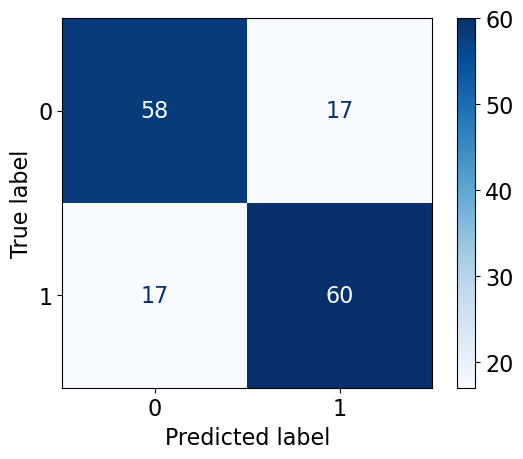

In [13]:
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Blues')
# Plot confusion matrix
# plot_confusion_matrix(mlp, X_test, y_test, normalize='pred', cmap='Blues')
# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
# plt.savefig('confusion-matrix-xgb.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
# find conflicts from predictions of two different classifiers
conflict_indices = [i for i in range(len(pred_rf)) if pred_rf[i] != pred_xgb[i]]
print(conflict_indices)

[8, 24, 38, 58, 67, 69, 73, 90, 92, 113, 128, 146, 147]

### Plot samples that are misclassified

In [44]:
c1 = test.ids[8]
c2 = test.ids[24]
print(c1, c2)

S(=O)(=O)(N(c1cc(C(=O)NC(Cc2ccccc2)C(O)C[NH2+]Cc2cc(ccc2)C(F)(F)F)c(cc1)C)c1ccccc1)C Fc1cc(cc(F)c1)CC(NC(=O)C)C(O)C[NH2+]C1(CC\C(=N\O)\CC1)c1cc(ccc1)C(C)(C)C


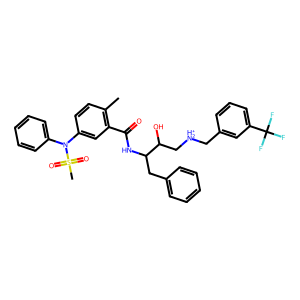

In [45]:
s1 = Chem.MolFromSmiles(c1)
Draw.MolToImage(s1)

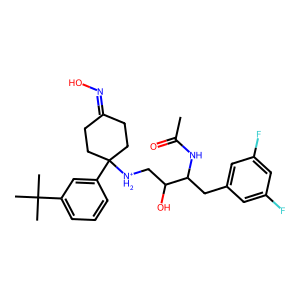

In [46]:
s2 = Chem.MolFromSmiles(c2)
Draw.MolToImage(s2)

### Explain such examples with LIME

In [47]:
feature_names = ["fp_%s"  % x for x in range(1024)]
explainer = lime_tabular.LimeTabularExplainer(train_x, 
                                              feature_names=feature_names, 
                                              categorical_features=feature_names,
                                              class_names=['inactive', 'active'], 
                                              discretize_continuous=True)

In [48]:
exp_rf = explainer.explain_instance(test_x[8], rf.predict_proba, num_features=100, top_labels=1)
exp_svm = explainer.explain_instance(test_x[8], svm.predict_proba, num_features=100, top_labels=1)
exp_mlp = explainer.explain_instance(test_x[8], mlp.predict_proba, num_features=100, top_labels=1)
exp_xgb = explainer.explain_instance(test_x[8], xgb_classifier.predict_proba, num_features=100, top_labels=1)

In [49]:
def fp_mol(mol, fp_length=1024):
    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of SMILES strings that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=1024)
    retval = feat._featurize(mol)
    for k, v in retval.items():
        index = k % fp_length
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    return d

# What fragments activated what fingerprints in our active molecule?
my_fragments = fp_mol(Chem.MolFromSmiles(test.ids[26]))

### Different fragments are activated

In [50]:
fragment_weight = dict(exp_svm.as_map()[1])
df_svm = [{'feature': list(my_fragments[i])[0], 'importance': fragment_weight[i]} for i in (my_fragments) if i in fragment_weight]
df_svm = pd.DataFrame(df_svm)
df_svm

,feature,importance
0,cc(c)C(CC)[NH2+]C,-0.045933
1,cCC,0.029256
2,cncc(c)C,-0.036467
3,,0.043802
4,cc(C)cc(c)F,-0.028113
5,CO,0.022332
6,cc(c)F,-0.034217
7,ccnc(c)O,-0.027360
8,,0.029964
9,cc(n)OC(C)(C)C,0.035723


In [51]:
fragment_weight = dict(exp_mlp.as_map()[1])
df_mlp = [{'feature': list(my_fragments[i])[0], 'importance': fragment_weight[i]} for i in (my_fragments) if i in fragment_weight]
df_mlp = pd.DataFrame(df_mlp)
df_mlp

,feature,importance
0,ccc(c(c)F)C(F)(F)F,-0.084240
1,ccc(cn)CC,-0.079296
2,cc(C)cc(c)C,-0.143349
3,ccn,-0.094899
4,ccc(c(n)O)C(C)[NH2+],0.070182


In [52]:
fragment_weight = dict(exp_rf.as_map()[1])
df_rf = [{'feature': list(my_fragments[i])[0], 'importance': fragment_weight[i]} for i in (my_fragments) if i in fragment_weight]
df_rf = pd.DataFrame(df_rf)
df_rf

,feature,importance
0,cncc(c)C,-0.082364
1,cc(c)C(F)(F)F,0.033611
2,,0.017663
3,CC[NH2+]C(C)c,-0.020550
4,ccc(c(c)F)C(F)(F)F,-0.016611
5,CC1(O)CCC1,-0.024278
6,cc(c)C,-0.023311
7,ccn,-0.020338


In [53]:
fragment_weight = dict(exp_xgb.as_map()[0])
df_xgb = [{'feature': list(my_fragments[i])[0], 'importance': fragment_weight[i]} for i in (my_fragments) if i in fragment_weight]
df_xgb = pd.DataFrame(df_xgb)
df_xgb

,feature,importance
0,CC(=O)NC(C)C,-0.056220
1,,-0.049617
2,ccc(c(c)F)C(F)(F)F,0.054024
3,ccc(cn)CC,0.103587
4,cc(C)cc(c)C,0.216936
5,CC1(O)CCC1,0.080263
6,CNC(C)=O,0.089026
7,cCC(C)(C)C,0.052141
8,ccn,0.091947


In [66]:
def bar_plot(feature_importance_df, name=None):
    feature_importance_df = feature_importance_df.iloc[::-1]

    fig, ax = plt.subplots(figsize=(5, 5))

    # Create a list of colors where positive importances are blue and negative importances are red
    colors = ['#ff0d57' if importance >= 0 else '#00AEEF' for importance in feature_importance_df['importance']]

    # Create a horizontal bar chart
    print(feature_importance_df['feature'].values)
    bars = ax.bar(feature_importance_df['feature'].values,  feature_importance_df['importance'].values, color=colors)
    ax.set_facecolor('white')

    # ax.set_xticks([])

    # Add a vertical line at x=0
    # ax.axvline(0, color='#4E4E50', linewidth=2)
    # ax.tick_params(axis='y', labelsize=12)  
    # # Add the values at the end of the bars
    # for bar in bars:
    #     width = bar.get_width()
    #     print(width)
    #     label_y_pos = bar.get_y() + bar.get_height() / 2
    #     if width < 0:  # if the value is negative
    #         ax.text(0, label_y_pos, s=f'{width:.2f}', va='center', ha='right', fontsize=8)
    #     else:  # if the value is positive
    #         ax.text(0.01, label_y_pos, s=f'{width:.2f}', va='center', ha='left', fontsize=8)
    plt.savefig(name, bbox_inches='tight', dpi=300)
    # Show the plot
    plt.show()

### We can plot and save such plots

['ccn' 'cCC(C)(C)C' 'CNC(C)=O' 'CC1(O)CCC1' 'cc(C)cc(c)C' 'ccc(cn)CC'
 'ccc(c(c)F)C(F)(F)F' '' 'CC(=O)NC(C)C']


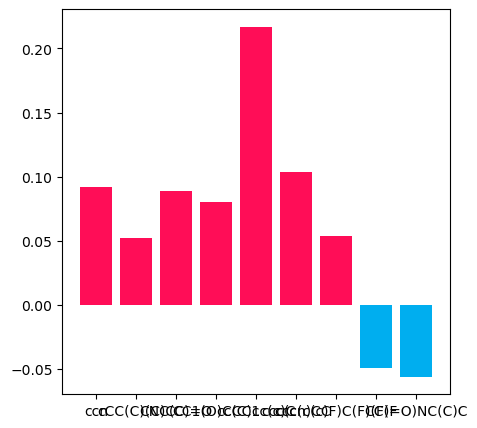

In [67]:
bar_plot(df_xgb, 's1-8-xgblatest.png')